In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('./cleaned_train.csv')
df['claims_am'] = df['claims_am'].fillna(0)
df.head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,...,gender,shop_am,shop_use,retired,gold_status,outcome_profit,outcome_damage_inc,outcome_damage_amount,score_pos,score_neg
0,5.429346,0.000000,8.071531,6.790097,1.945910,9.615872,0,0,0,0,...,1,0.000000,0,0,0,7.491456,0,0.000000,0.652958,0.532814
1,5.594711,2.833213,7.428333,0.000000,0.000000,6.621406,0,0,0,1,...,1,0.000000,0,0,0,7.422840,1,6.722221,0.000000,0.795526
2,5.648974,3.178054,7.422971,0.000000,0.000000,6.621406,0,0,0,1,...,1,0.000000,0,0,0,6.910152,0,0.000000,0.167165,0.136915
3,5.429346,0.000000,7.430114,0.000000,0.000000,0.000000,0,0,0,0,...,0,0.000000,0,0,0,7.488064,0,0.000000,0.000000,0.889793
4,8.316789,6.936343,8.139149,6.666957,1.098612,9.546884,0,0,1,0,...,0,7.282906,1,0,0,8.052532,0,0.000000,0.410495,0.654370


In [ ]:
df.isnull().sum()

income_am                0
profit_last_am           0
profit_am                0
damage_am                0
damage_inc               0
crd_lim_rec              0
credit_use_ic            0
gluten_ic                0
lactose_ic               0
insurance_ic             0
spa_ic                   0
empl_ic                  0
cab_requests             0
married_cd               0
bar_no                   0
sport_ic                 0
neighbor_income          0
age                      0
marketing_permit         0
urban_ic                 0
dining_ic                0
presidential             0
client_segment           0
sect_empl                0
prev_stay                0
prev_all_in_stay         0
divorce                  0
fam_adult_size           0
children_no              0
tenure_mts               0
company_ic               0
claims_no                0
claims_am                0
nights_booked            0
gender                   0
shop_am                  0
shop_use                 0
r

In [ ]:
from random import Random
df_shuffle = df.sample(frac=1, random_state=123)

In [ ]:
df_shuffle.shape

(4851, 44)

In [ ]:
"""
Splitting the data into training and testing sets and dropping the damage features 
since they are not counted/subtracted from the profit thus are irrelevant for the profit
"""
from sklearn.model_selection import train_test_split

df_shuffle.drop(['outcome_damage_inc', 'outcome_damage_amount'],axis=1, inplace=True)

X = df_shuffle.drop(['outcome_profit'],axis=1)
y = df_shuffle['outcome_profit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
def get_all_bool_cols(df):
    bool_cols = []
    for col in df.keys():
        if str(df[col].unique()) == "[0 1]":
            bool_cols.append(col)
    return bool_cols

In [ ]:
from sklearn.preprocessing import RobustScaler

feat = df_shuffle.drop(get_all_bool_cols(df_shuffle),axis=1)
feat.drop('outcome_profit',axis=1, inplace=True)
num_feat = feat.select_dtypes(include=['int16','int64', 'float64']).columns

scaler = RobustScaler()
scaler.fit(X_train[num_feat])

X_train_stan = X_train.copy()
X_test_stan = X_test.copy()

X_train_stan[num_feat] = scaler.transform(X_train[num_feat])
X_test_stan[num_feat] = scaler.transform(X_test[num_feat])

# Linear regression

## Polynomial regression

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

avg_scores = [None] * 3

for deg in np.arange(1,4):
  reg_poly = Pipeline([('poly', PolynomialFeatures(degree=deg)),
                      ('linear', LinearRegression(fit_intercept=False))])
  
  scores = cross_val_score(reg_poly,X_train_stan, y_train, scoring = 'r2', cv=3)

  avg_scores[deg-1] = scores.mean()
    
  print("Order "+str(deg)+": avg R^2 = "+str( avg_scores[deg-1]))

Order 1: avg R^2 = 0.5028840569519243
Order 2: avg R^2 = -7.767436167327819e+16
Order 3: avg R^2 = -15814.435643181632


## We clearly see a downard trend the higher the polynomial goes

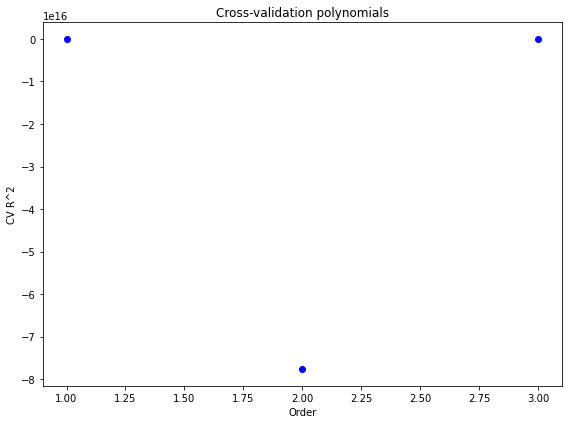

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(np.arange(1,4), avg_scores, c='b', label='data')
plt.axis('tight')
plt.title("Cross-validation polynomials")
ax.set_xlabel("Order");
ax.set_ylabel("CV R^2");
plt.tight_layout()
plt.show()

<p>The third point in the chart looks a bit bugged probably because the value is too big/small</p>

## Looking at the graph of r2 scores it's safe to say that a low polynomial works best

In [ ]:
"""
Training a linear regression model with best polynomial value
"""
poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train_stan)
X_test_poly = poly.transform(X_test_stan)

best_poly_model = LinearRegression(fit_intercept=False)
best_poly_model.fit(X_train_poly,y_train)

best_poly_model_train_score = best_poly_model.score(X_train_poly,y_train)
best_poly_model_test_score = best_poly_model.score(X_test_poly,y_test)

print(f"train score: {best_poly_model_train_score}")
print(f"test score: {best_poly_model_test_score}")

train score: 0.5266320368844073
test score: 0.5394423262592045


### Trees

## Single tree

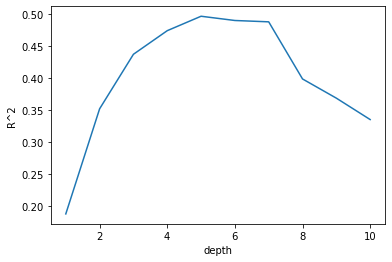

The best depth is 5
The validated score is 0.49623787682948095


In [ ]:
from sklearn.tree import DecisionTreeRegressor  

depth = np.arange(1,11)
cv_scores = []
sd_scores = []

for d in depth:
  dec_tree = DecisionTreeRegressor(random_state = 0, max_depth=d)
  scores = cross_val_score(dec_tree, X_train_stan, y_train,  cv=5)
  cv_scores.append(scores.mean())
  sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))
 
max_value = max(cv_scores)
best_index = cv_scores.index(max_value)

plt.plot(depth, cv_scores)
plt.xlabel('depth')
plt.ylabel('R^2')

plt.show()
print('The best depth is', depth[best_index])
print('The validated score is', max_value)

In [ ]:
from sklearn import tree  

best_tree_model = DecisionTreeRegressor(random_state = 0, max_depth=depth[best_index])  
best_tree_model.fit(X_train_stan, y_train) 

best_tree_model_train_score = best_tree_model.score(X_train_stan, y_train)
best_tree_model_test_score = best_tree_model.score(X_test_stan, y_test)

print(f"R2 of the best tree model train set: {best_tree_model_train_score}")
print(f"R2 of the best tree model test set: {best_tree_model_test_score}")

R2 of the best tree model train set: 0.5612249585615832
R2 of the best tree model test set: 0.5291596179259023


# Forrest

In [ ]:
"""
forrest with random search
"""
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

criterion =['mse','mae']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 300)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 10, num = 7)]
min_samples_split = [int(x) for x in np.linspace(2, 10, num = 7)]
min_samples_leaf = [int(x) for x in np.linspace(1, 10, num = 8)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 500, num = 400)]

random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=5, random_state=42, n_jobs=-1)

rf_random.fit(X_train_stan, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['mse', 'mae'],
                                        'max_depth': [1, 2, 4, 5, 7, 8, 10],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_nodes': [10, 11, 12, 13, 14,
                                                           16, 17, 18, 19, 21,
                                                           22, 23, 24, 25, 27,
                                                           28, 29, 30, 32, 33,
                                                           34, 35, 37, 38, 39,
                                                           40, 41, 43, 44, 45, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 6, 7,
                                                      

In [ ]:
print(f"Best trainig score for randomg search: {rf_random.score(X_train_stan, y_train)}")
print(f"Best test score for randomg search: {rf_random.score(X_test_stan, y_test)}")

Best trainig score for randomg search: 0.7557325520481859
Best test score for randomg search: 0.6267820164544344


In [ ]:
rf_random.best_params_

{'n_estimators': 451,
 'min_samples_split': 7,
 'min_samples_leaf': 6,
 'max_leaf_nodes': 488,
 'max_features': 'auto',
 'max_depth': 10,
 'criterion': 'mse'}

### Visualising the random features

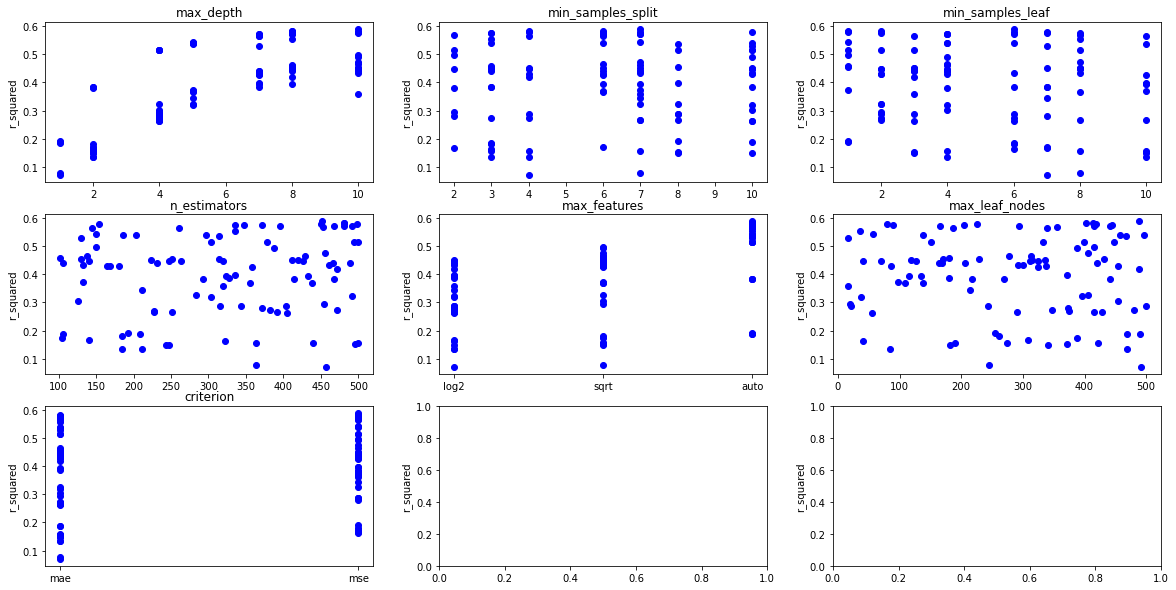

In [ ]:
out = pd.DataFrame(rf_random.cv_results_)
xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_max_features', 'param_max_leaf_nodes', 'param_criterion']

fig, axs = plt.subplots(3,3, figsize=(20,10))

axs[0,0].scatter(out['param_max_depth'], out['mean_test_score'], c='blue');
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out['param_min_samples_split'], out['mean_test_score'], c='blue');
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out['param_min_samples_leaf'], out['mean_test_score'], c='blue');
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out['param_n_estimators'], out['mean_test_score'], c='blue');
axs[1,0].set_title('n_estimators')

axs[1,1].scatter(out['param_max_features'], out['mean_test_score'], c='blue');
axs[1,1].set_title('max_features')

axs[1,2].scatter(out['param_max_leaf_nodes'], out['mean_test_score'], c='blue');
axs[1,2].set_title('max_leaf_nodes')

axs[2,0].scatter(out['param_criterion'], out['mean_test_score'], c='blue');
axs[2,0].set_title('criterion')

for ax in axs.flat:
    ax.set(ylabel='r_squared')

In [ ]:
"""
forrest with grid search
"""
from sklearn.model_selection import GridSearchCV

criterion =['mse']
n_estimators = [440,450,500]
max_features = ['auto']
max_depth = [7,10]
min_samples_split = [6,7,8]
min_samples_leaf = [4,6,7]
max_leaf_nodes = [485,488,495]

grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes}

rf = RandomForestRegressor()
rf_grid = GridSearchCV(estimator = rf, param_grid = grid,
                               cv = 3, verbose=2,  n_jobs=-1)

rf_grid.fit(X_train_stan, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': [7, 10],
                         'max_features': ['auto'],
                         'max_leaf_nodes': [485, 488, 495],
                         'min_samples_leaf': [4, 6, 7],
                         'min_samples_split': [6, 7, 8],
                         'n_estimators': [440, 450, 500]},
             verbose=2)

In [ ]:
rf_grid.best_params_

{'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': 495,
 'min_samples_leaf': 4,
 'min_samples_split': 7,
 'n_estimators': 450}

In [ ]:
params = rf_grid.best_params_
best_forrest_model = RandomForestRegressor(**params)
best_forrest_model.fit(X_train_stan, y_train)

RandomForestRegressor(max_depth=10, max_leaf_nodes=495, min_samples_leaf=4,
                      min_samples_split=7, n_estimators=450)

In [ ]:
best_forrest_model_train_score = best_forrest_model.score(X_train_stan, y_train)
best_forrest_model_test_score = best_forrest_model.score(X_test_stan, y_test)

print(f"R2 of the best forrest model train set: {best_forrest_model_train_score}")
print(f"R2 of the best forrest model test set: {best_forrest_model_test_score}")

R2 of the best forrest model train set: 0.7767825634472576
R2 of the best forrest model test set: 0.6331499301130568


## RNN

In [ ]:
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.model_selection import cross_val_score

Radius = np.linspace(15,70,20)    
cv_scores = []
sd_scores = []
for k in Radius:
    Rnn = RadiusNeighborsRegressor(radius= k)
    scores = cross_val_score(Rnn, X_train_stan, y_train,  cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

E:\programming\anaconda\lib\site-packages\sklearn\neighbors\_regression.py:421: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
E:\programming\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\programming\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "E:\programming\anaconda\lib\site-packages\sklearn\metrics\_scorer.py", line 90, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "E:\programming\anaconda\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "E:\programming\anaconda\lib\site-packages\sklearn\base.py", line 554, in score
    r

E:\programming\anaconda\lib\site-packages\sklearn\neighbors\_regression.py:421: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
E:\programming\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\programming\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "E:\programming\anaconda\lib\site-packages\sklearn\metrics\_scorer.py", line 90, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "E:\programming\anaconda\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "E:\programming\anaconda\lib\site-packages\sklearn\base.py", line 554, in score
    r

E:\programming\anaconda\lib\site-packages\sklearn\neighbors\_regression.py:421: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
E:\programming\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "E:\programming\anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "E:\programming\anaconda\lib\site-packages\sklearn\metrics\_scorer.py", line 90, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "E:\programming\anaconda\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "E:\programming\anaconda\lib\site-packages\sklearn\base.py", line 554, in score
    r

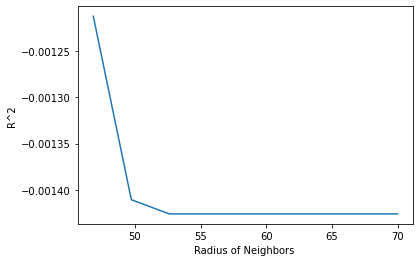

In [ ]:
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(Radius, cv_scores)
plt.xlabel('Radius of Neighbors ')
plt.ylabel('R^2')
plt.axhline(y=max_value-1.96*sd_scores[max_index])

plt.show()

### We see that the RNN model doesn't score very wel

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

K = np.arange(1,65)    
cv_scores = []
sd_scores = []
for k in K:
    knn = KNeighborsRegressor(n_neighbors= k)
    scores = cross_val_score(knn, X_train_stan, y_train,  cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

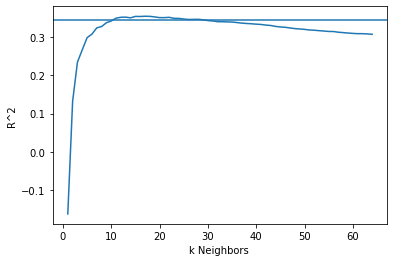

In [ ]:
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(K, cv_scores)
plt.xlabel('k Neighbors ')
plt.ylabel('R^2')
plt.axhline(y=max_value-1.96*sd_scores[max_index])

plt.show()

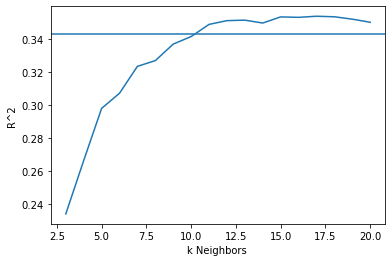

The best k is 17


In [ ]:
plt.plot(K[2 : 20],cv_scores[2 :20])
plt.xlabel('k Neighbors ')
plt.ylabel('R^2')

plt.axhline(y=max_value-1.96*sd_scores[max_index])


plt.show()
print('The best k is', K[max_index])

In [ ]:
best_knn_model = KNeighborsRegressor(n_neighbors=K[max_index])
best_knn_model.fit(X_train_stan, y_train)

KNeighborsRegressor(n_neighbors=17)

In [ ]:
best_knn_model_train_score = best_knn_model.score(X_train_stan, y_train)
best_knn_model_test_score = best_knn_model.score(X_test_stan, y_test)

print(f"R2 of the best knn model train set: {best_knn_model_train_score}")
print(f"R2 of the best knn model test set: {best_knn_model_test_score}")

R2 of the best knn model train set: 0.4422403750339077
R2 of the best knn model test set: 0.34941443888848167


## Lasso Regression

In [ ]:
"""
design poly features
"""
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train_stan)
X_test_poly = poly.transform(X_test_stan)
X_train_poly.shape

(3880, 13244)

In [ ]:
"""
simple lin reg lasso with default alpha
"""
from sklearn import linear_model
linreg_lasso = linear_model.Lasso()
linreg_lasso.fit(X_train_poly, y_train)
print('R2 : %.3f' % linreg_lasso.score(X_train_poly, y_train))
print('R2 : %.3f' % linreg_lasso.score(X_test_poly, y_test))

R2 : 0.099
R2 : -0.119


In [ ]:
"""
CV lasso
"""
from sklearn.linear_model import LassoCV
best_lasso_model = LassoCV(cv=5, random_state=123, max_iter=600).fit(X_train_poly, y_train)
print('R2 : %.3f' % best_lasso_model.score(X_train_poly, y_train))
print('R2 : %.3f' % best_lasso_model.score(X_test_poly, y_test))

E:\programming\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18743869020778448, tolerance: 0.06616076761111672
  model = cd_fast.enet_coordinate_descent(
E:\programming\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.60010160038007, tolerance: 0.06177333251125549
  model = cd_fast.enet_coordinate_descent(
E:\programming\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86.93767851072046, tolerance: 0.06177333251125549
  model = cd_fast.enet_coordinate_descent(
E:\programming\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

R2 : 0.540
R2 : 0.400


In [ ]:
best_lasso_model.alpha_

0.016476896022944887

In [ ]:
best_lasso_model_train_score = best_lasso_model.score(X_train_poly, y_train)
best_lasso_model_test_score = best_lasso_model.score(X_test_poly, y_test)

print(f"R2 of the best lasso model train set: {best_lasso_model_train_score}")
print(f"R2 of the best lasso model test set: {best_lasso_model_test_score}")

R2 of the best lasso model train set: 0.5400757635492615
R2 of the best lasso model test set: 0.40019874154484125


# Gradient boosting

### random search gbm

In [ ]:

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

criterion =['mse','mae']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 50)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
min_samples_split = [int(x) for x in np.linspace(2, 10, num = 9)]
min_samples_leaf = [int(x) for x in np.linspace(1, 10, num = 10)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 500, num = 50)]
loss = ['ls','lad','huber','quantile']
learning_rate = [round(x,5) for x in np.logspace(start = -3, stop = -0.01, num = 10)]

random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes,
               'loss': loss,
               'learning_rate': learning_rate}

gbm = GradientBoostingRegressor()
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = random_grid, n_iter = 50, 
                               cv = 3, verbose=2, random_state=42, n_jobs=-1)
gbm_random.fit(X_train_stan, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'criterion': ['mse', 'mae'],
                                        'learning_rate': [0.001, 0.00215,
                                                          0.00462, 0.00992,
                                                          0.02132, 0.04583,
                                                          0.09848, 0.21162,
                                                          0.45476, 0.97724],
                                        'loss': ['ls', 'lad', 'huber',
                                                 'quantile'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                   

In [ ]:
print(f"gbm random model train score: {gbm_random.score(X_train_stan, y_train)}")
print(f"gbm random model test score: {gbm_random.score(X_test_stan, y_test)}")

gbm random model train score: 0.7893320609543256
gbm random model test score: 0.6984524526345847


In [ ]:
gbm_random.best_params_

{'n_estimators': 491,
 'min_samples_split': 5,
 'min_samples_leaf': 3,
 'max_leaf_nodes': 240,
 'max_features': 'log2',
 'max_depth': 4,
 'loss': 'huber',
 'learning_rate': 0.04583,
 'criterion': 'mse'}

In [ ]:
random_gbm_model = GradientBoostingRegressor(**params)
random_gbm_model.fit(X_train_stan, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=10, max_features='auto',
                          max_leaf_nodes=495, min_samples_leaf=4,
                          min_samples_split=7, n_estimators=450)

In [ ]:
random_gbm_model_train_score = random_gbm_model.score(X_train_stan, y_train)
random_gbm_model_test_score = random_gbm_model.score(X_test_stan, y_test)

print(f"R2 of the best random gbm model train set: {random_gbm_model_train_score}")
print(f"R2 of the best random gbm model test set: {random_gbm_model_test_score}")

R2 of the best random gbm model train set: 0.9999974191383825
R2 of the best random gbm model test set: 0.6834534908645671


### Checking the impact of different values

In [ ]:
out = pd.DataFrame(gbm_random.cv_results_)
out.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_leaf_nodes,param_max_features,param_max_depth,param_loss,param_learning_rate,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,43.152965,0.577415,0.014334,0.001246,246,3,8,160,sqrt,3,quantile,0.97724,mae,"{'n_estimators': 246, 'min_samples_split': 3, ...",-0.530850,-0.417450,-0.112611,-0.353637,0.176607,47
1,27.030726,0.523121,0.057001,0.013492,467,6,4,230,auto,7,lad,0.21162,mse,"{'n_estimators': 467, 'min_samples_split': 6, ...",0.633062,0.574083,0.659108,0.622084,0.035569,2
2,20.392728,0.431791,0.043664,0.001247,206,10,2,390,log2,9,huber,0.02132,mse,"{'n_estimators': 206, 'min_samples_split': 10,...",0.601618,0.539040,0.612157,0.584272,0.032272,11
3,96.468138,2.496194,0.033334,0.002055,279,4,4,140,log2,8,huber,0.04583,mae,"{'n_estimators': 279, 'min_samples_split': 4, ...",0.635066,0.564655,0.636777,0.612166,0.033603,7
4,613.019437,17.809010,0.030999,0.004547,312,10,4,380,auto,7,lad,0.04583,mae,"{'n_estimators': 312, 'min_samples_split': 10,...",0.555752,0.513150,0.558628,0.542510,0.020794,20


In [ ]:
out.mean_test_score 

0    -0.353637
1     0.622084
2     0.584272
3     0.612166
4     0.542510
5    -0.008682
6     0.076704
7     0.511199
8     0.384134
9     0.612208
10    0.209992
11    0.307265
12    0.520383
13    0.101722
14    0.473903
15    0.571366
16   -0.397407
17   -0.038112
18    0.166534
19    0.539586
20    0.610907
21   -0.351528
22   -0.137759
23    0.584073
24    0.620072
25    0.555041
26    0.488666
27    0.642923
28   -0.587923
29    0.103914
30    0.616663
31    0.582845
32    0.523829
33    0.621707
34    0.052907
35    0.284773
36    0.045003
37    0.523446
38    0.529111
39    0.091042
40    0.581941
41    0.261730
42    0.547044
43    0.577269
44    0.600301
45    0.225668
46   -0.910944
47    0.030069
48    0.584150
49    0.602186
Name: mean_test_score, dtype: float64

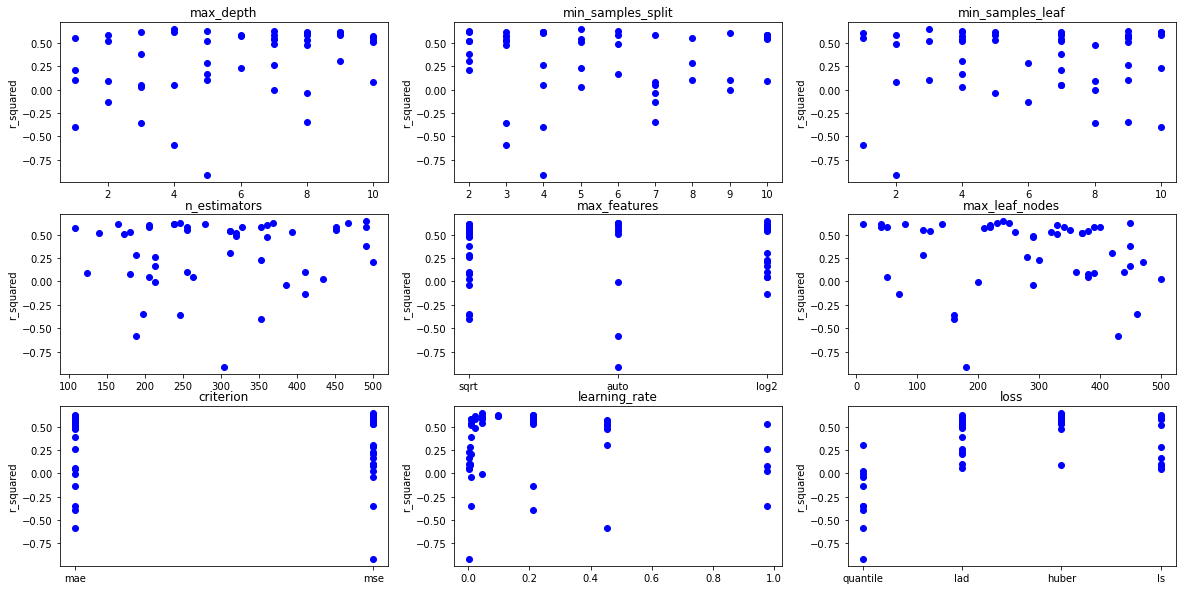

In [ ]:
out2 = out


xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_max_features', 'param_max_leaf_nodes', 'param_criterion']

fig, axs = plt.subplots(3,3, figsize=(20,10))

axs[0,0].scatter(out2['param_max_depth'], out2['mean_test_score'], c='blue');
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out2['param_min_samples_split'], out2['mean_test_score'], c='blue');
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out2['param_min_samples_leaf'], out2['mean_test_score'], c='blue');
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out2['param_n_estimators'], out2['mean_test_score'], c='blue');
axs[1,0].set_title('n_estimators')

axs[1,1].scatter(out2['param_max_features'], out2['mean_test_score'], c='blue');
axs[1,1].set_title('max_features')

axs[1,2].scatter(out2['param_max_leaf_nodes'], out2['mean_test_score'], c='blue');
axs[1,2].set_title('max_leaf_nodes')

axs[2,0].scatter(out2['param_criterion'], out2['mean_test_score'], c='blue');
axs[2,0].set_title('criterion')

axs[2,1].scatter(out2['param_learning_rate'], out2['mean_test_score'], c='blue');
axs[2,1].set_title('learning_rate')

axs[2,2].scatter(out2['param_loss'], out2['mean_test_score'], c='blue');
axs[2,2].set_title('loss')


for ax in axs.flat: ax.set(ylabel='r_squared')

### grid search gbm

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

criterion =['mae']
n_estimators = [491,495,500]
max_features = ['log2']
max_depth = [4,5]
min_samples_split = [4,5]
min_samples_leaf = [3,4]
max_leaf_nodes = [230,240,250]
learning_rate = [0.04583]
loss = ['huber']

grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
            'max_leaf_nodes': max_leaf_nodes,
               'learning_rate': learning_rate,
               'loss':loss}

gbm = GradientBoostingRegressor()
gbm_grid = GridSearchCV(estimator = gbm, param_grid = grid,
                               cv = 3, verbose=2,  n_jobs=-1)

gbm_grid.fit(X_train_stan, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


E:\programming\anaconda\lib\site-packages\sklearn\ensemble\_gb.py:1630: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mae'], 'learning_rate': [0.04583],
                         'loss': ['huber'], 'max_depth': [4, 5],
                         'max_features': ['log2'],
                         'max_leaf_nodes': [230, 240, 250],
                         'min_samples_leaf': [3, 4],
                         'min_samples_split': [4, 5],
                         'n_estimators': [491, 495, 500]},
             verbose=2)

In [ ]:
gbm_grid.best_params_

{'criterion': 'mae',
 'learning_rate': 0.04583,
 'loss': 'huber',
 'max_depth': 5,
 'max_features': 'log2',
 'max_leaf_nodes': 230,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 495}

In [ ]:
gbm_grid.best_score_

0.6362777672338676

In [ ]:
params = gbm_grid.best_params_
best_gbm_model = GradientBoostingRegressor(**params)
best_gbm_model.fit(X_train_stan, y_train)

E:\programming\anaconda\lib\site-packages\sklearn\ensemble\_gb.py:1630: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


GradientBoostingRegressor(criterion='mae', learning_rate=0.04583, loss='huber',
                          max_depth=5, max_features='log2', max_leaf_nodes=230,
                          min_samples_leaf=4, min_samples_split=4,
                          n_estimators=495)

In [ ]:
best_gbm_model_train_score = best_gbm_model.score(X_train_stan, y_train)
best_gbm_model_test_score = best_gbm_model.score(X_test_stan, y_test)

print(f"R2 of the best gbm model train set: {best_gbm_model_train_score}")
print(f"R2 of the best gbm model test set: {best_gbm_model_test_score}")

R2 of the best gbm model train set: 0.7996541182565824
R2 of the best gbm model test set: 0.6812570754030095


## Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score
adareg = AdaBoostRegressor(random_state = 123, n_estimators=10)
adareg.fit(X_train_stan, y_train)
pred = adareg.predict(X_test_stan)
adareg_r2 = r2_score(y_test, pred)
print("RMSE:", adareg_r2)

RMSE: 0.47141624616633626


## XGBoost

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xg
from sklearn.metrics import r2_score
xgbr = xg.XGBRegressor(objective = 'reg:squarederror', n_estimators = 10, seed = 123)
xgbr.fit(X_train_stan, y_train)
pred = xgbr.predict(X_test_stan)
xgb_r2 = r2_score(y_test, pred)
print("RMSE:", xgb_r2)

ModuleNotFoundError: No module named 'xgboost'

# Comparing the different models

## R2

In [ ]:
'''
poly
'''
print(f"R2 of the best polynomial regression model train set: {best_poly_model_train_score}")
print(f"R2 of the best polynomial regression model test set: {best_poly_model_test_score}")
'''
tree
'''
print(f"R2 of the best tree model train set: {best_tree_model_train_score}")
print(f"R2 of the best tree model test set: {best_tree_model_test_score}")
'''
forrest
'''
print(f"R2 of the best forrest model train set: {best_forrest_model_train_score}")
print(f"R2 of the best forrest model test set: {best_forrest_model_test_score}")
'''
knn
'''
print(f"R2 of the best knn model train set: {best_knn_model_train_score}")
print(f"R2 of the best knn model test set: {best_knn_model_test_score}")
'''
lasso
'''
print(f"R2 of the best lasso model train set: {best_lasso_model_train_score}")
print(f"R2 of the best lasso model test set: {best_lasso_model_test_score}")
'''
GBM
'''
print(f"R2 of the best gbm model train set: {best_gbm_model_train_score}")
print(f"R2 of the best gbm model test set: {best_gbm_model_test_score}")
'''
GBM- random
'''
print(f"R2 of the best random gbm model train set: {gbm_random.score(X_train_stan, y_train)}")
print(f"R2 of the best random gbm model test set: {gbm_random.score(X_test_stan, y_test)}")

R2 of the best polynomial regression model train set: 0.5266320368844073
R2 of the best polynomial regression model test set: 0.5394423262592045
R2 of the best tree model train set: 0.5612249585615832
R2 of the best tree model test set: 0.5291596179259023
R2 of the best forrest model train set: 0.7767825634472576
R2 of the best forrest model test set: 0.6331499301130568
R2 of the best knn model train set: 0.4422403750339077
R2 of the best knn model test set: 0.34941443888848167
R2 of the best lasso model train set: 0.5400757635492615
R2 of the best lasso model test set: 0.40019874154484125
R2 of the best gbm model train set: 0.7996541182565824
R2 of the best gbm model test set: 0.6812570754030095
R2 of the best random gbm model train set: 0.7893320609543256
R2 of the best random gbm model test set: 0.6984524526345847


### We see that the Random forrest and GBM R^2 scores on the test sets are pretty simular

## MSE

In [ ]:
from sklearn.metrics import mean_squared_error

pred_forrest = best_forrest_model.predict(X_test_stan)
pred_gbm = gbm_random.predict(X_test_stan)

mse_forrest = mean_squared_error(y_test,pred_forrest)
mse_gbm = mean_squared_error(y_test,pred_gbm)

print(f"mse forrest: {mse_forrest}, mse gbm:  {mse_gbm}")

mse forrest: 0.0837757547730182, mse gbm:  0.06886293735278708


#### It looks like GBM is the best performing model, even if it might be slightly over fitted so let's use that one on the score dataset

## Testing the models on the score dataset

#### The score dataset has been cleaned in the same way the trainV2 dataset was

In [ ]:
df_score = pd.read_csv('./cleaned_score.csv')
df_score.head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,...,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,score_pos,score_neg
0,8.641356,8.371242,9.064274,0.000000,0.000000,8.987322,0,0,1,0,...,0.0,0.0,3.970292,0,8.429177,1,0,1,0.481080,0.580214
1,8.291797,2.302585,8.146419,0.000000,0.000000,9.433564,0,0,0,1,...,0.0,0.0,1.609438,1,0.000000,0,0,0,0.000000,0.000000
2,7.055313,4.418841,8.341649,6.013715,1.609438,9.392745,0,0,0,1,...,0.0,0.0,5.407172,1,0.000000,0,0,0,0.360106,0.568299
3,7.804659,6.674561,7.659171,0.000000,0.000000,0.000000,0,0,0,1,...,0.0,0.0,1.386294,1,0.000000,0,0,0,0.000000,0.000000
4,6.853299,5.407172,7.619233,0.000000,0.000000,0.000000,0,0,1,0,...,0.0,0.0,3.555348,0,0.000000,0,0,0,0.000000,0.000000


In [ ]:
'''
making predictions for all 500 rows in the score dataset
'''
profit_predictions = gbm_random.predict(df_score)
profit_predictions

array([7.93585853, 7.64883199, 7.81667841, 7.78770007, 8.08521582,
       7.99487323, 7.65863125, 8.03145701, 7.93965492, 7.97552098,
       7.83926648, 7.76394441, 7.77265365, 7.81931182, 7.92169292,
       8.01358524, 7.79727926, 7.93050719, 7.34858242, 8.08908151,
       7.65234481, 8.09514635, 7.8103565 , 7.93302463, 8.04096769,
       7.73617453, 8.04216889, 8.15875219, 7.81879527, 7.52744984,
       7.98665929, 7.97276275, 7.66101877, 7.7018888 , 7.73797681,
       7.94921478, 7.78194499, 7.79938809, 8.07183476, 7.63641966,
       7.66963895, 7.84506705, 7.82785496, 8.30592651, 7.82222546,
       7.97353626, 8.03090155, 7.71711959, 7.68367934, 7.71773802,
       7.84235107, 8.10265025, 8.00426817, 7.91750204, 7.90032949,
       7.85847877, 8.03693081, 8.06445402, 7.84226419, 7.76717157,
       8.03959794, 7.893213  , 7.82628161, 7.92932509, 7.79241288,
       7.88770926, 8.09214146, 7.80627326, 8.03620999, 7.96445761,
       8.13545934, 8.29877658, 8.25932231, 7.77688614, 7.92285

In [ ]:
df_score['predicted_profit'] = profit_predictions
df_score.head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,...,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,score_pos,score_neg,predicted profit
0,8.641356,8.371242,9.064274,0.000000,0.000000,8.987322,0,0,1,0,...,0.0,3.970292,0,8.429177,1,0,1,0.481080,0.580214,7.935859
1,8.291797,2.302585,8.146419,0.000000,0.000000,9.433564,0,0,0,1,...,0.0,1.609438,1,0.000000,0,0,0,0.000000,0.000000,7.648832
2,7.055313,4.418841,8.341649,6.013715,1.609438,9.392745,0,0,0,1,...,0.0,5.407172,1,0.000000,0,0,0,0.360106,0.568299,7.816678
3,7.804659,6.674561,7.659171,0.000000,0.000000,0.000000,0,0,0,1,...,0.0,1.386294,1,0.000000,0,0,0,0.000000,0.000000,7.787700
4,6.853299,5.407172,7.619233,0.000000,0.000000,0.000000,0,0,1,0,...,0.0,3.555348,0,0.000000,0,0,0,0.000000,0.000000,8.085216


## Whitening the black box

### GBM scored the best but whit this model it is harder to determine which factors are important

In [ ]:
list(zip(X_train.columns, best_gbm_model.feature_importances_))

[('income_am', 0.04038171419874816),
 ('profit_last_am', 0.02670025800792617),
 ('profit_am', 0.0940405257277638),
 ('damage_am', 0.0388263219420018),
 ('damage_inc', 0.00886078837653787),
 ('crd_lim_rec', 0.03581845385972445),
 ('credit_use_ic', 0.004802303225118552),
 ('gluten_ic', 0.003375324784764966),
 ('lactose_ic', 0.0031767073358219115),
 ('insurance_ic', 0.008258921140297774),
 ('spa_ic', 0.006382895488476369),
 ('empl_ic', 0.0011293808249101447),
 ('cab_requests', 0.02335226992086649),
 ('married_cd', 0.0039651491064570535),
 ('bar_no', 0.012991206764520652),
 ('sport_ic', 0.009770875809004303),
 ('neighbor_income', 0.050014384904686904),
 ('age', 0.046260632484270856),
 ('marketing_permit', 0.010319931857590246),
 ('urban_ic', 0.007052282557668007),
 ('dining_ic', 0.0011258412700706055),
 ('presidential', 0.0182182670500576),
 ('client_segment', 0.015495878558313574),
 ('sect_empl', 0.004728801808854206),
 ('prev_stay', 0.009235768078355945),
 ('prev_all_in_stay', 0.00884508

In [ ]:
'''
We expect the sum of the feature importances to be 1
'''
best_gbm_model.feature_importances_.sum()

1.0

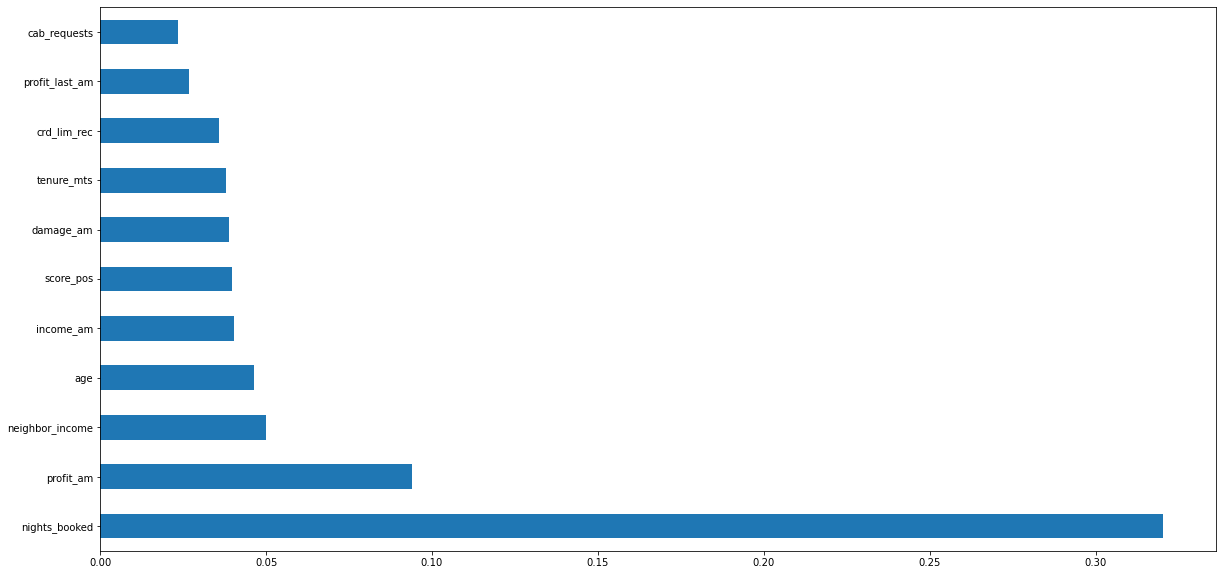

In [ ]:
'''
Plotting the feature importance to make it more readable
'''
from matplotlib import pyplot as plt

plt.figure(figsize=(20,10))

feat_importances = pd.Series(best_gbm_model.feature_importances_, index=X.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()

In [ ]:
'''
let's see if the features affect the outcome postively or negatively
'''

from sklearn.linear_model import LinearRegression

pred_train =best_gbm_model.predict(X_train_stan)

X = pd.DataFrame(X_train_stan)
X.columns = X_train.columns
predictors =  X_train.columns
y = np.array((pred_train-pred_train.mean())/np.sqrt(pred_train.var())).reshape(-1, 1)

reg = LinearRegression(normalize=True).fit(X[[predictors[0]]], y)
beta = pd.Series(reg.coef_[0])
names = pd.Series(predictors[0])
for i in np.arange(1,(X.shape[1])):
    reg = LinearRegression(normalize=True).fit(X[[predictors[i]]], y)
    beta_help = pd.Series(reg.coef_[0])
    names_help = pd.Series(predictors[i])
    beta = pd.concat([beta,beta_help], axis=0)
    names = pd.concat([names,names_help], axis=0)
betas = pd.concat([names,beta],axis=1)
betas.sort_values(by=[1])

,0,1
0,nights_booked,-0.908751
0,crd_lim_rec,-0.409342
0,insurance_ic,-0.223804
0,prev_all_in_stay,-0.142632
0,cab_requests,-0.122685
0,retired,-0.091038
0,score_pos,-0.078418
0,marketing_permit,-0.078061
0,sport_ic,-0.028587
0,tenure_mts,-0.025271


### Findings
<p>
    <b>Positive:</b> We see that the features: "presidential", "gold_status" and "gluten_ic" have the biggest positive impact on the model.<br> It seems pretty logical for people staying in the presidential suite to be more profitable since they're probably richer than the average customer and are staying in a more expensive room. I'm not entirely sure what gold client statue entails but I imagine it being something like a VIP, so it would be to be expected for them to be more profitable than the average client. The 3rd biggest feature is bigger suprise, apprently people that are allergic to gluten are also better customers.<br>
    <br><b>Negative:</b> Apperently the biggest factor that negatively impacts the profit is the amount of nights booked which seems counter intuitive to me. I don't know what the crd_lim_rec features means. People using insurance being less profitable seems logical since the hotel has to reimburse them if something happens.
</p>

### Why is a prediction what it is

In [ ]:
!pip install lime

In [ ]:
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer


# creating the explainer function
explainer = LimeTabularExplainer(X_train_stand.values, mode="regression", feature_names=X_train.columns)

# storing a new observation
i = 100
X_test_stand = pd.DataFrame(X_test_stand)
X_test_stand.columns = X_train.columns

X_observation = X_test_stand.iloc[[i], :]

ModuleNotFoundError: No module named 'lime'

In [ ]:
best_gbm_model.predict(X_observation)

In [ ]:
explanation = explainer.explain_instance(X_observation.values[0], rf_gridBest.predict)
explanation.show_in_notebook(show_table=True, show_all=False)

# Exporting the best model

In [ ]:
'''
Saving the best model so we can import it and use it without having to retrain it
'''
import pickle

name = 'best_gbm_model.sav'
pickle.dump(best_gbm_model, open(name, 'wb'))